## Midterm Activity 3
Logistic Regression

Objectives:
1. Use Google Colab or Jupyter Notebook and Python libraries (such as scikit-learn) to develop a binary
logistic regression model for a given dataset.
2. Interpret the model and evaluate the model’s performance based on different metrics (confusion
matrix and accuracy, precision, recall, and F1 score).

#### Perform the following and answer the questions:

2. Apply data exploration and then preprocessing, as deemed necessary, to ensure the proper training of
the model. For example:<br>
    ○ Check and manage unavailable values or outliers<br>
    ○ Choose the “best” features to use by considering the p-value for each feature<br>
    ○ Check for imbalances and apply a sampling technique such as SMOTE


Total observations: 4238
Original features: 16

First 5 Rows:
   gender  age  educationLevel  currentSmoker  cigsPerDay  BPMeds  \
0       1   39             4.0              0         0.0     0.0   
1       0   46             2.0              0         0.0     0.0   
2       1   48             1.0              1        20.0     0.0   
3       0   61             3.0              1        30.0     0.0   
4       0   46             3.0              1        23.0     0.0   

   prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                0             0         0    195.0  106.0   70.0  26.97   
1                0             0         0    250.0  121.0   81.0  28.73   
2                0             0         0    245.0  127.5   80.0  25.34   
3                0             1         0    225.0  150.0   95.0  28.58   
4                0             0         0    285.0  130.0   84.0  23.10   

   heartRate  glucose  tenYearCHD  
0       80.0     77.0        

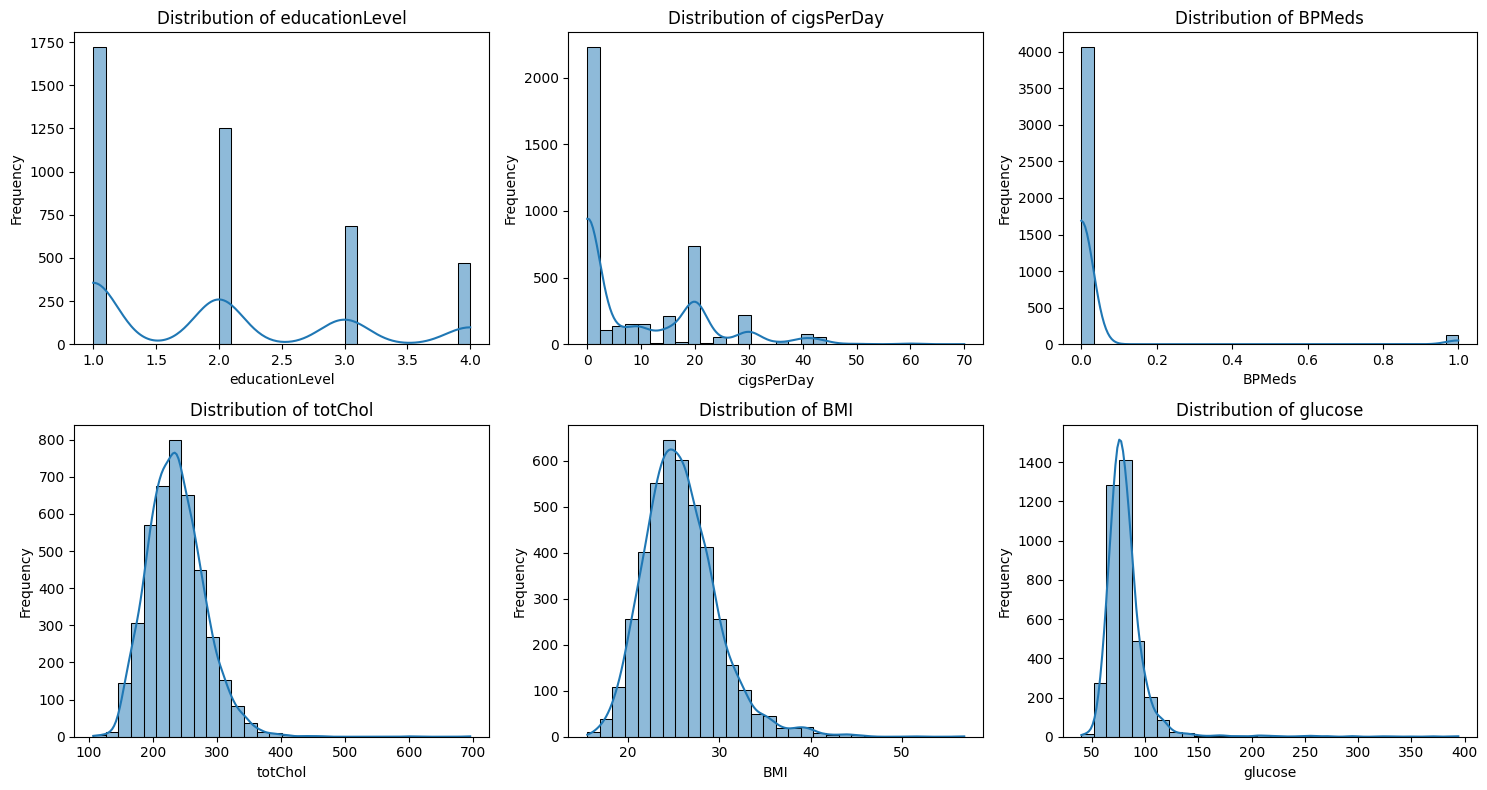


Top 10 correlations with tenYearCHD:
tenYearCHD      1.000000
age             0.225256
sysBP           0.216429
prevalentHyp    0.177603
diaBP           0.145299
glucose         0.125544
diabetes        0.097317
gender          0.088428
BPMeds          0.087489
totChol         0.082184
Name: tenYearCHD, dtype: float64


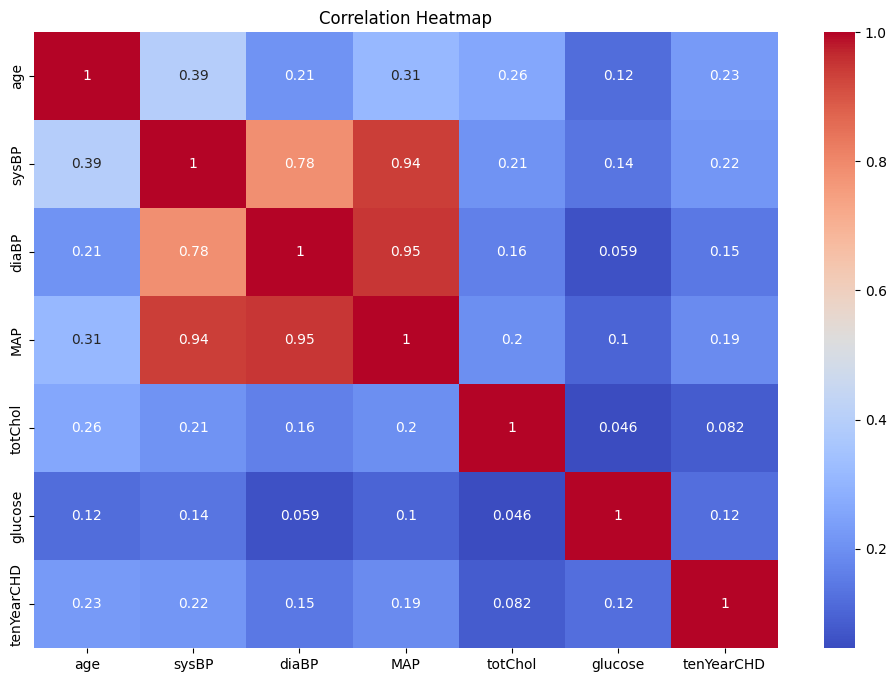


Features after encoding: 22


In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                            precision_score, recall_score, f1_score,
                            classification_report, roc_auc_score, 
                            RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("../data/heart_disease_prediction.csv")

# Print dataset dimensions
print(f"\nTotal observations: {len(df)}")
print(f"Original features: {len(df.columns)}")

# Data exploration
print("\nFirst 5 Rows:")
print(df.head())
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe())


# Check Features with Missing Values
nan_counts = df.isna().sum()
print("\nMissing values per column:")
print(nan_counts[nan_counts > 0])
features = ['educationLevel', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'glucose']
n_rows = (len(features) + 3 - 1) // 3


# Create Histograms to see Skewness
plt.figure(figsize=(3 * 5, n_rows * 4))
for i, col in enumerate(features, 1):
   plt.subplot(n_rows, 3, i)
   sns.histplot(df[col], kde=True, bins=30)
   plt.title(f'Distribution of {col}')
   plt.xlabel(col)
   plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Correlation analysis
corr_matrix = df.corr()
print("\nTop 10 correlations with tenYearCHD:")
print(corr_matrix['tenYearCHD'].abs().sort_values(ascending=False).head(10))

# Impute missing values
num_cols = ['totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay']
cat_cols = ['educationLevel', 'BPMeds']
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
df[num_cols] = imputer_num.fit_transform(df[num_cols])
df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

# Feature engineering
df['MAP'] = (2*df['diaBP'] + df['sysBP']) / 3
df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3])

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['educationLevel', 'BMI_Category'], drop_first=True)

# Heatmap for key variables
plt.figure(figsize=(12,8))
sns.heatmap(df[['age','sysBP','diaBP','MAP','totChol','glucose','tenYearCHD']].corr(), 
            annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Print final feature count
print(f"\nFeatures after encoding: {len(df.columns)}")

3. Set aside 10% of the dataset (will serve as unseen data). The remaining part of the data set (90%) can
be split <br> into an 80-20 proportion (training and testing data, respectively).

In [38]:
# 90-10 split training and testing data
train_df, test_df = train_test_split(
    df, 
    test_size=0.10, 
    stratify=df['tenYearCHD'],  # for imbalanced data
    random_state=42
)

print(f"Training size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Test size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

# 80-20 split training data
x = train_df.drop('tenYearCHD', axis=1)
y = train_df['tenYearCHD']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# Handle imbalance with SMOTE
smote = SMOTE()
x_train_sm, y_train_sm = smote.fit_resample(x_train, y_train)

# Standardize 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_sm)
x_test_scaled = scaler.transform(x_test)
test_scaled = scaler.transform(test_df.drop('tenYearCHD', axis=1))

# Train logistic regression model
lr_model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,  # Ensure convergence
    solver='liblinear',  # Better for smaller datasets
    penalty='l2'  # Regularization to prevent overfitting
)
lr_model.fit(x_train_scaled, y_train_sm)

Training size: 3814 (90.0%)
Test size: 424 (10.0%)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

4. Assess your model's performance, using the confusion matrix accuracy, precision,<br> recall, and F1
score. Interpret the performance of your model.


LOGISTIC REGRESSION VALIDATION PERFORMANCE


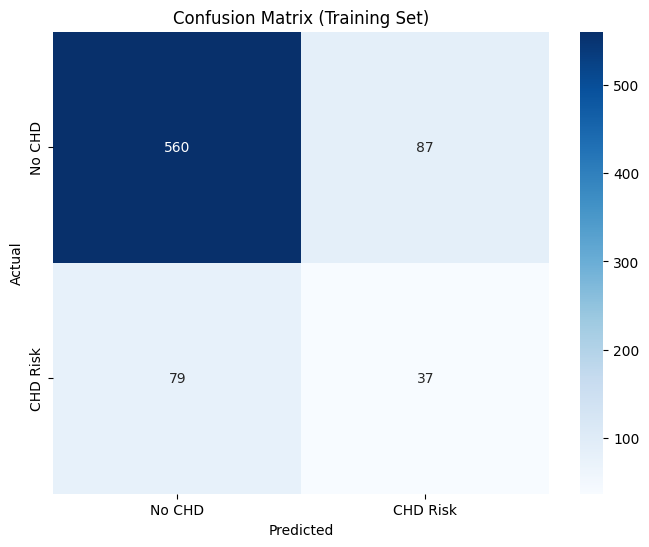


              precision    recall  f1-score   support

      No CHD       0.88      0.87      0.87       647
    CHD Risk       0.30      0.32      0.31       116

    accuracy                           0.78       763
   macro avg       0.59      0.59      0.59       763
weighted avg       0.79      0.78      0.79       763



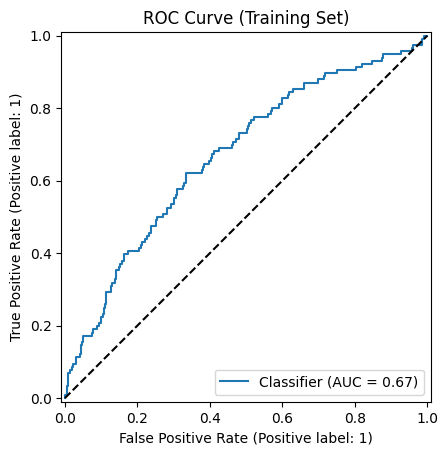

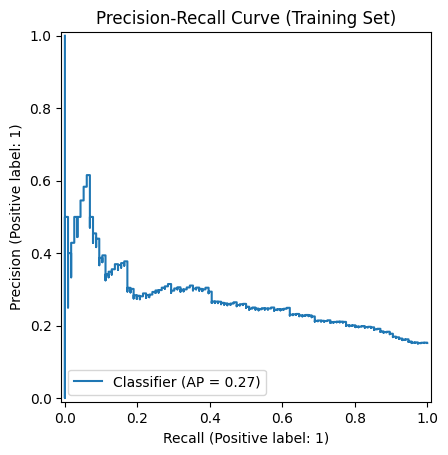


Training Set Performance:
      Metric     Value       Set
0   Accuracy  0.782438  Training
1  Precision  0.298387  Training
2     Recall  0.318966  Training
3   F1-Score  0.308333  Training
4    ROC-AUC  0.669389  Training

Log-Odds Equation:
log(p/(1-p)) = 0.6713 + -0.1187*gender + 0.6435*age + -0.3310*currentSmoker + 0.6942*cigsPerDay + 0.1190*BPMeds + -0.0040*prevalentStroke + -0.2368*prevalentHyp + 0.0044*diabetes + 0.0349*totChol + 0.3289*sysBP + -0.0077*diaBP + -0.1874*BMI + 0.0306*heartRate + 0.1300*glucose + 0.1659*MAP + 0.3205*educationLevel_2.0 + 0.3517*educationLevel_3.0 + 0.3503*educationLevel_4.0 + 2.5495*BMI_Category_1 + 2.8132*BMI_Category_2 + 2.0538*BMI_Category_3

LOGISTIC REGRESSION FEATURE IMPORTANCE
              Feature  Odds_Ratio
0           INTERCEPT    1.956841
1      BMI_Category_2   16.663142
2      BMI_Category_1   12.801040
3      BMI_Category_3    7.797588
4          cigsPerDay    2.002095
5                 age    1.903049
6  educationLevel_3.0    1.4215

In [39]:
# Function to calculate and display metrics
def evaluate_model(model, x, y, set_name="Training"):
    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No CHD', 'CHD Risk'],
                yticklabels=['No CHD', 'CHD Risk'])
    plt.title(f'Confusion Matrix ({set_name} Set)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Classification report
    print(f"\n{classification_report(y, y_pred, target_names=['No CHD', 'CHD Risk'])}")
    
    # ROC Curve
    RocCurveDisplay.from_predictions(y, y_proba)
    plt.title(f'ROC Curve ({set_name} Set)')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.show()
    
    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y, y_proba)
    plt.title(f'Precision-Recall Curve ({set_name} Set)')
    plt.show()
    
    # Metrics summary
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
        'Value': [accuracy, precision, recall, f1, roc_auc],
        'Set': [set_name]*5
    })
    
    print(f"\n{set_name} Set Performance:")
    print(metrics_df)
    
    return metrics_df

# Evaluate logistic regression on validation set
print("\n" + "="*50)
print("LOGISTIC REGRESSION VALIDATION PERFORMANCE")
print("="*50)
lr_val_metrics = evaluate_model(lr_model, x_test_scaled, y_test, "Training")

# Feature importance interpretation
coef_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': lr_model.coef_[0],
    'Odds_Ratio': np.exp(lr_model.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

# Add intercept to feature importance
intercept_df = pd.DataFrame({
    'Feature': ['INTERCEPT'],
    'Coefficient': lr_model.intercept_[0],
    'Odds_Ratio': np.exp(lr_model.intercept_[0])
})
coef_df = pd.concat([intercept_df, coef_df], ignore_index=True)

# Print model equation
print("\nLog-Odds Equation:")
print(f"log(p/(1-p)) = {lr_model.intercept_[0]:.4f} + " + 
      " + ".join([f"{coef:.4f}*{feat}" 
                 for feat, coef in zip(x_train.columns, lr_model.coef_[0])]))

print("\n" + "="*50)
print("LOGISTIC REGRESSION FEATURE IMPORTANCE")
print("="*50)
print(coef_df[['Feature', 'Odds_Ratio']].head(10))

5. Predict TenYearCHD on the remaining 10% unseen data.


LOGISTIC REGRESSION TEST PERFORMANCE


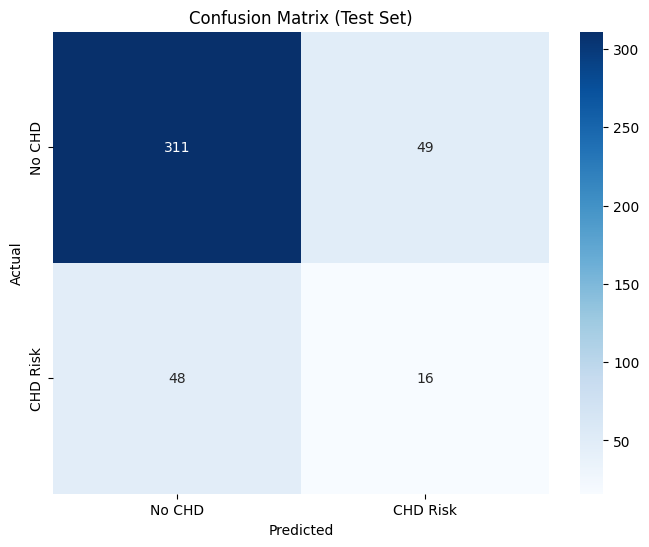


              precision    recall  f1-score   support

      No CHD       0.87      0.86      0.87       360
    CHD Risk       0.25      0.25      0.25        64

    accuracy                           0.77       424
   macro avg       0.56      0.56      0.56       424
weighted avg       0.77      0.77      0.77       424



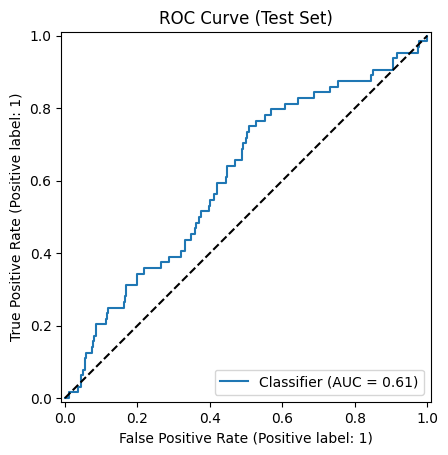

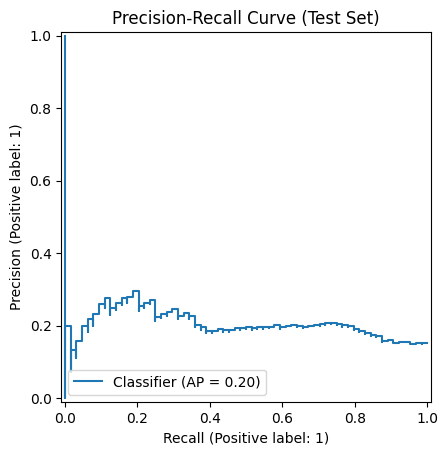


Test Set Performance:
      Metric     Value   Set
0   Accuracy  0.771226  Test
1  Precision  0.246154  Test
2     Recall  0.250000  Test
3   F1-Score  0.248062  Test
4    ROC-AUC  0.608984  Test


In [40]:
# Predict on unseen test data (10% holdout)
print("\n" + "="*50)
print("LOGISTIC REGRESSION TEST PERFORMANCE")
print("="*50)
lr_test_metrics = evaluate_model(lr_model, test_scaled, test_df['tenYearCHD'], "Test")
